In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-23 08:22:24.841993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 08:22:24.842100: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 08:22:24.842131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 08:22:24.851370: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [10]:
trainX, testX = scale_data(trainX, testX)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [13]:
n_classes = 6

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LSTM(128, activation="relu", return_sequences = True)(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [15]:
"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    # input_shape 튜플 풀기
    n_steps, n_features = input_shape
    
    inputs = keras.Input(shape=(n_steps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [16]:
"""
## Train and evaluate
"""

input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

2024-05-23 08:22:34.700031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-05-23 08:22:34.702330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 9)               39945     ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 9)               0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 128, 9)               18        ['dropout[0][0]']         

 conv1d_2 (Conv1D)           (None, 128, 9)               1161      ['dropout_5[0][0]']           
                                                                                                  
 layer_normalization_5 (Lay  (None, 128, 9)               18        ['conv1d_2[0][0]']            
 erNormalization)                                                                                 
                                                                                                  
 tf.__operators__.add_5 (TF  (None, 128, 9)               0         ['layer_normalization_5[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_4[0][0
                                                                    ]']                           
                                                                                                  
 multi_head_attention_3 (Mu  (None, 128, 9)               39945     ['tf.__operators__.add_5[0][0]
 ltiHeadAt

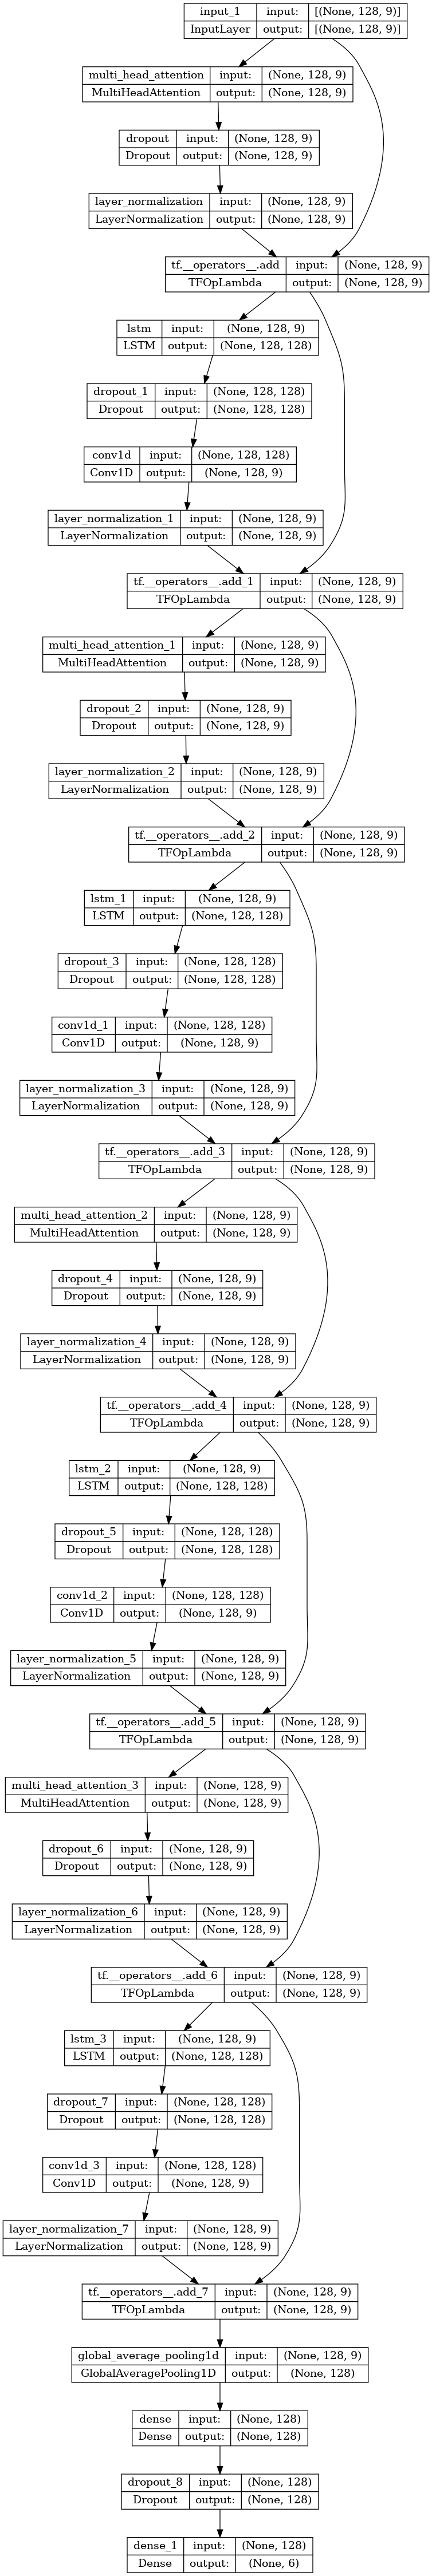

In [17]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [18]:
history = model.fit(
    X_train,
    y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=300,
    batch_size=128,
    callbacks=callbacks,
)

model.evaluate(testX, testy_one_hot, verbose=1)

Epoch 1/300


2024-05-23 08:22:45.987250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-23 08:22:46.631887: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa26c003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 08:22:46.631927: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-05-23 08:22:46.631937: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-05-23 08:22:46.637596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 08:22:46.720442: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 [==============================] - 51s 867ms/step - loss: 1.6967 - accuracy: 0.2868 - val_loss: 1.5955 - val_accuracy: 0.3436
Epoch 2/300
41/41 [==============================] - 35s 846ms/step - loss: 1.5366 - accuracy: 0.3546 - val_loss: 1.4560 - val_accuracy: 0.3663
Epoch 3/300
41/41 [==============================] - 35s 846ms/step - loss: 1.4481 - accuracy: 0.3700 - val_loss: 1.3795 - val_accuracy: 0.4139
Epoch 4/300
41/41 [==============================] - 35s 867ms/step - loss: 1.3847 - accuracy: 0.4250 - val_loss: 1.3354 - val_accuracy: 0.4882
Epoch 5/300
41/41 [==============================] - 36s 876ms/step - loss: 1.3990 - accuracy: 0.4011 - val_loss: 1.3607 - val_accuracy: 0.4207
Epoch 6/300
41/41 [==============================] - 35s 862ms/step - loss: 1.3694 - accuracy: 0.4019 - val_loss: 1.3248 - val_accuracy: 0.4456
Epoch 7/300
41/41 [==============================] - 35s 865ms/step - loss: 1.3337 - accuracy: 0.4254 - val_loss: 1.2933 - val_accuracy: 0.4737
Epoc

41/41 [==============================] - 35s 850ms/step - loss: 0.7731 - accuracy: 0.7248 - val_loss: 0.7251 - val_accuracy: 0.7475
Epoch 58/300
41/41 [==============================] - 36s 871ms/step - loss: 0.7589 - accuracy: 0.7268 - val_loss: 0.7176 - val_accuracy: 0.7489
Epoch 59/300
41/41 [==============================] - 35s 846ms/step - loss: 0.7513 - accuracy: 0.7386 - val_loss: 0.7109 - val_accuracy: 0.7498
Epoch 60/300
41/41 [==============================] - 34s 842ms/step - loss: 0.7546 - accuracy: 0.7365 - val_loss: 0.7033 - val_accuracy: 0.7543
Epoch 61/300
41/41 [==============================] - 36s 869ms/step - loss: 0.7457 - accuracy: 0.7379 - val_loss: 0.6958 - val_accuracy: 0.7656
Epoch 62/300
41/41 [==============================] - 35s 866ms/step - loss: 0.7411 - accuracy: 0.7408 - val_loss: 0.6894 - val_accuracy: 0.7593
Epoch 63/300
41/41 [==============================] - 39s 950ms/step - loss: 0.7279 - accuracy: 0.7532 - val_loss: 0.6833 - val_accuracy: 0.761

41/41 [==============================] - 35s 858ms/step - loss: 0.5508 - accuracy: 0.8033 - val_loss: 0.4821 - val_accuracy: 0.8214
Epoch 114/300
41/41 [==============================] - 35s 858ms/step - loss: 0.5485 - accuracy: 0.8074 - val_loss: 0.4783 - val_accuracy: 0.8209
Epoch 115/300
41/41 [==============================] - 34s 843ms/step - loss: 0.5584 - accuracy: 0.7993 - val_loss: 0.4779 - val_accuracy: 0.8218
Epoch 116/300
41/41 [==============================] - 34s 842ms/step - loss: 0.5463 - accuracy: 0.8059 - val_loss: 0.4755 - val_accuracy: 0.8241
Epoch 117/300
41/41 [==============================] - 36s 872ms/step - loss: 0.5386 - accuracy: 0.8024 - val_loss: 0.4758 - val_accuracy: 0.8237
Epoch 118/300
41/41 [==============================] - 35s 867ms/step - loss: 0.5466 - accuracy: 0.8070 - val_loss: 0.4728 - val_accuracy: 0.8246
Epoch 119/300
41/41 [==============================] - 35s 859ms/step - loss: 0.5452 - accuracy: 0.8030 - val_loss: 0.4684 - val_accuracy:

41/41 [==============================] - 36s 869ms/step - loss: 0.4761 - accuracy: 0.8195 - val_loss: 0.4126 - val_accuracy: 0.8350
Epoch 170/300
41/41 [==============================] - 36s 876ms/step - loss: 0.4821 - accuracy: 0.8226 - val_loss: 0.4115 - val_accuracy: 0.8364
Epoch 171/300
41/41 [==============================] - 35s 862ms/step - loss: 0.4724 - accuracy: 0.8257 - val_loss: 0.4103 - val_accuracy: 0.8332
Epoch 172/300
41/41 [==============================] - 35s 848ms/step - loss: 0.4681 - accuracy: 0.8272 - val_loss: 0.4089 - val_accuracy: 0.8368
Epoch 173/300
41/41 [==============================] - 35s 863ms/step - loss: 0.4715 - accuracy: 0.8249 - val_loss: 0.4102 - val_accuracy: 0.8359
Epoch 174/300
41/41 [==============================] - 36s 869ms/step - loss: 0.4679 - accuracy: 0.8305 - val_loss: 0.4076 - val_accuracy: 0.8364
Epoch 175/300
41/41 [==============================] - 35s 864ms/step - loss: 0.4637 - accuracy: 0.8290 - val_loss: 0.4065 - val_accuracy:

41/41 [==============================] - 35s 846ms/step - loss: 0.4217 - accuracy: 0.8443 - val_loss: 0.3757 - val_accuracy: 0.8450
Epoch 226/300
41/41 [==============================] - 35s 859ms/step - loss: 0.4337 - accuracy: 0.8385 - val_loss: 0.3756 - val_accuracy: 0.8454
Epoch 227/300
41/41 [==============================] - 35s 859ms/step - loss: 0.4198 - accuracy: 0.8430 - val_loss: 0.3750 - val_accuracy: 0.8468
Epoch 228/300
41/41 [==============================] - 35s 849ms/step - loss: 0.4197 - accuracy: 0.8461 - val_loss: 0.3741 - val_accuracy: 0.8481
Epoch 229/300
41/41 [==============================] - 36s 892ms/step - loss: 0.4251 - accuracy: 0.8426 - val_loss: 0.3752 - val_accuracy: 0.8468
Epoch 230/300
41/41 [==============================] - 35s 858ms/step - loss: 0.4274 - accuracy: 0.8408 - val_loss: 0.3755 - val_accuracy: 0.8459
Epoch 231/300
41/41 [==============================] - 36s 868ms/step - loss: 0.4214 - accuracy: 0.8443 - val_loss: 0.3758 - val_accuracy:

41/41 [==============================] - 31s 760ms/step - loss: 0.4994 - accuracy: 0.8173 - val_loss: 0.4991 - val_accuracy: 0.8024
Epoch 282/300
93/93 [==============================] - 9s 99ms/step - loss: 0.5690 - accuracy: 0.7852


[0.5689687728881836, 0.7852053046226501]

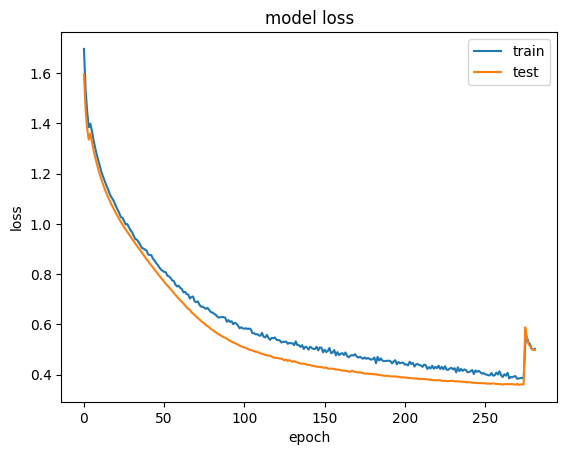

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

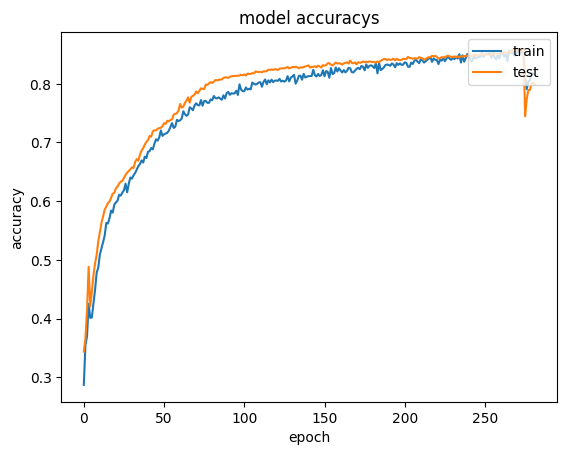

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracys')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

93/93 [==============================] - 9s 100ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

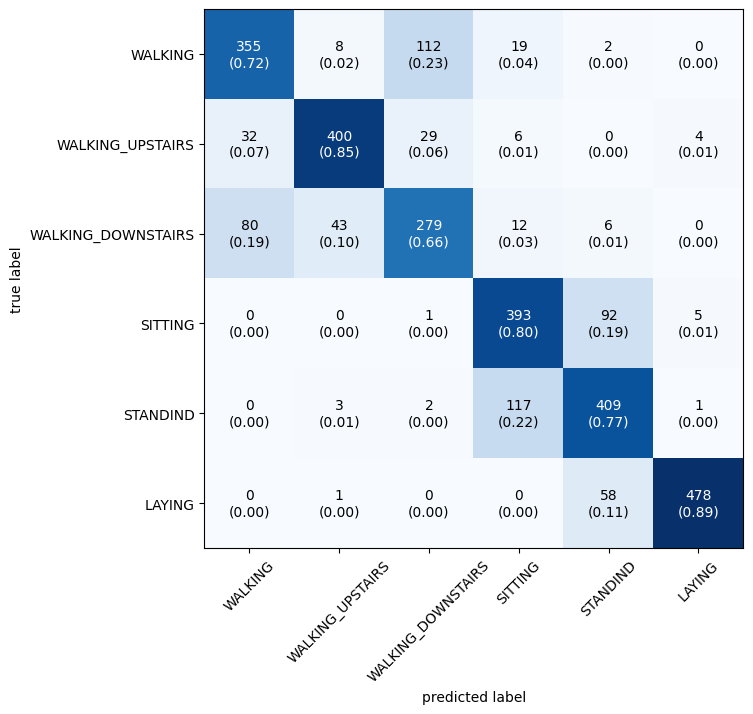

In [22]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

In [23]:
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[355   8 112  19   2   0]
 [ 32 400  29   6   0   4]
 [ 80  43 279  12   6   0]
 [  0   0   1 393  92   5]
 [  0   3   2 117 409   1]
 [  0   1   0   0  58 478]]
0.7852052935188327
0.7869806775524213
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       496
           1       0.88      0.85      0.86       471
           2       0.66      0.66      0.66       420
           3       0.72      0.80      0.76       491
           4       0.72      0.77      0.74       532
           5       0.98      0.89      0.93       537

    accuracy                           0.79      2947
   macro avg       0.79      0.78      0.78      2947
weighted avg       0.79      0.79      0.79      2947

